# Preprocessing in Remote Sensing: Merging, Cloud Masking and Normalization

---

This section presents three essential preprocessing steps used to prepare remote sensing data before analysis:

- **Merging (or mosaicking)** consists in combining multiple raster tiles covering adjacent geographical areas into a single, continuous image. It ensures spatial consistency across a region of interest, especially when working with satellite data acquired in strips or tiles.

- **Cloud masking** involves detecting and removing cloud-covered pixels from optical imagery. Clouds and their shadows obscure the Earth's surface, making accurate analysis difficult. Several methods exist, from basic thresholding (e.g., using QA bands) to more advanced machine learning and temporal filtering approaches.

- **Normalization** aims to adjust the range and distribution of reflectance values across images, especially when acquired under different illumination conditions or sensor settings. It improves the consistency between scenes and is crucial for time-series analysis or multi-date mosaics.

These preprocessing steps are necessary to ensure the quality and comparability of remote sensing data. They help mitigate artifacts and inconsistencies that could bias further processing or interpretation. More advanced techniques like atmospheric correction or BRDF normalization can further enhance data quality and will be covered in later chapters.

---

## Import

In [1]:
from osgeo import gdal,gdalconst,osr
gdal.UseExceptions()

import numpy as np
import matplotlib.pyplot as plt

from module_display import display_images #you can find the module in the folder utility

---

## Merging

In this example, we will merge *T59GNM_20190305T222531_B03_20m.jp2* and *T59GPM_20190305T222531_B03_20m.jp2*. This two image intersect but it's not mandatory for a merging. You just need to have the same projection and the same resolution. If we have an intersect, the last file in the list overwrite the intersect part.

In [ ]:
inputs = ["T59GNM_20190305T222531_B03_20m.jp2", "T59GPM_20190305T222531_B03_20m.jp2"]
output = "merged.tif"

ds=gdal.Warp(
    output,
    inputs,
    format="GTiff",
    srcNodata=-9999,
    dstNodata=-9999,
    resampleAlg="bilinear"
)
ds=None

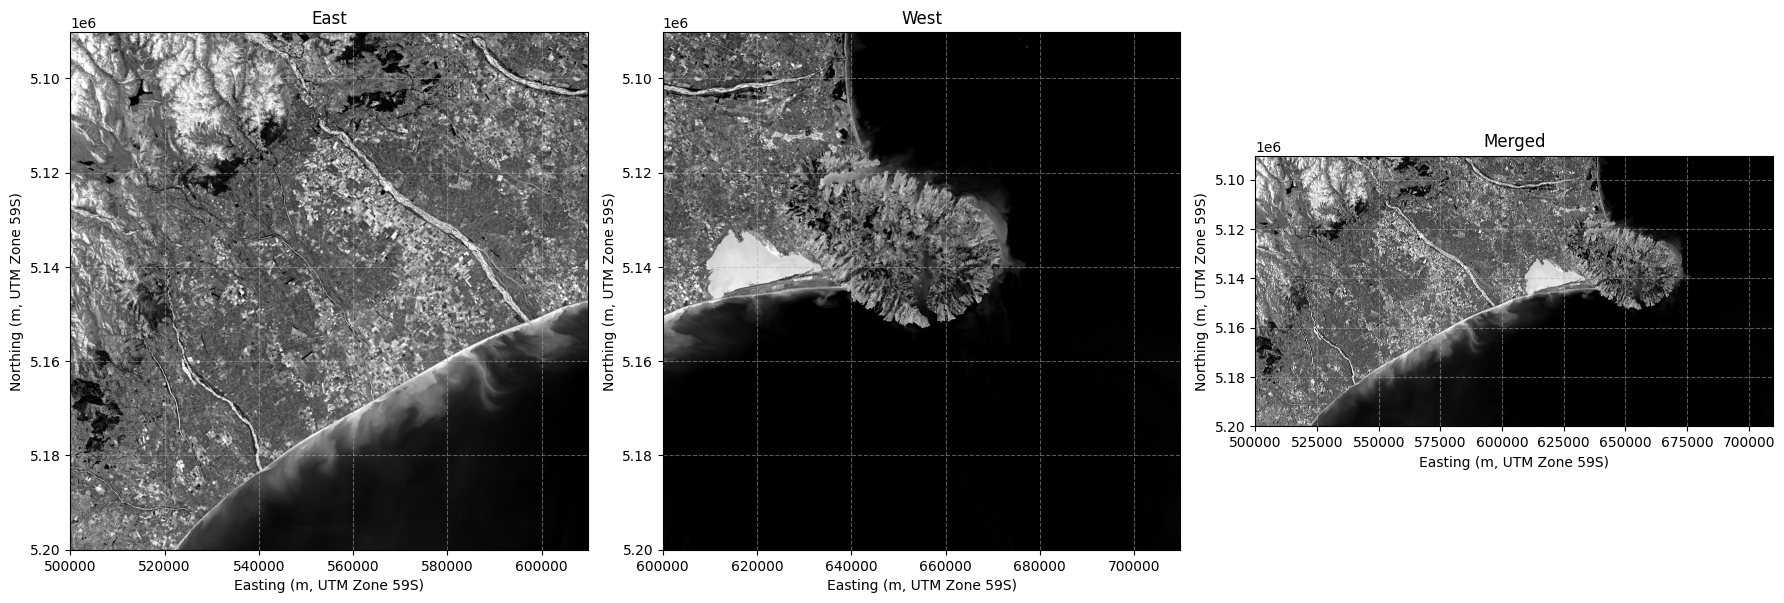

In [12]:
path = ["T59GNM_20190305T222531_B03_20m.jp2","T59GPM_20190305T222531_B03_20m.jp2","merged.tif"]
title=["East","West","Merged"]
axe=("Easting (m, UTM Zone 59S)","Northing (m, UTM Zone 59S)")
display_images(path,title,axis_labels=axe)

---

# Cloud Masking

We will use this process on the file *T59GPM_20181110T222539_B03_20m.jp2*. It contains clouds that are not useful for future processing. The file is a Sentinel-2 L2A product so there is a band call SCL (Scene Classification Layer) attached to him. 

**Band SLC and his twelve classification :**
- 0 : No Data (Missing data)	
- 1 : Saturated or defective pixel 	
- 2 : Topographic casted shadows (called "Dark features/Shadows" for data before 2022-01-25)
- 3 : Cloud shadows	
- 4 : Vegetation	
- 5 : Not-vegetated	
- 6 : Water
- 7 : Unclassified	
- 8 : Cloud medium probability
- 9 : Cloud high probability	
- 10 : Thin cirrus	
- 11 : Snow or ice

We applied a mask when the pixel value of the SCL correspond to the class 3,8,9 and 10.

In [ ]:
band_path = "data_copernicus_unzip/S2B_MSIL2A_20181110T222539_N0500_R029_T59GPM_20230802T132516.SAFE/GRANULE/L2A_T59GPM_A008778_20181110T222535/IMG_DATA/R20m/T59GPM_20181110T222539_B03_20m.jp2"
scl_path = "data_copernicus_unzip/S2B_MSIL2A_20181110T222539_N0500_R029_T59GPM_20230802T132516.SAFE/GRANULE/L2A_T59GPM_A008778_20181110T222535/IMG_DATA/R20m/T59GPM_20181110T222539_SCL_20m.jp2"
output_path = "B03_masked.tif"

fill_value = -9999
band_ds = gdal.Open(band_path)
band = band_ds.GetRasterBand(1).ReadAsArray()
scl_ds = gdal.Open(scl_path)
scl = scl_ds.ReadAsArray()

mask = np.isin(scl, [3, 8, 9, 10]) 
band_masked = np.where(mask, fill_value, band)

driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(output_path, band.shape[1], band.shape[0], 1, gdal.GDT_Int16)
out_ds.SetGeoTransform(band_ds.GetGeoTransform())
out_ds.SetProjection(band_ds.GetProjection())
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(band_masked)
out_band.SetNoDataValue(fill_value)

out_ds = None
band_ds=None
scl_ds=None

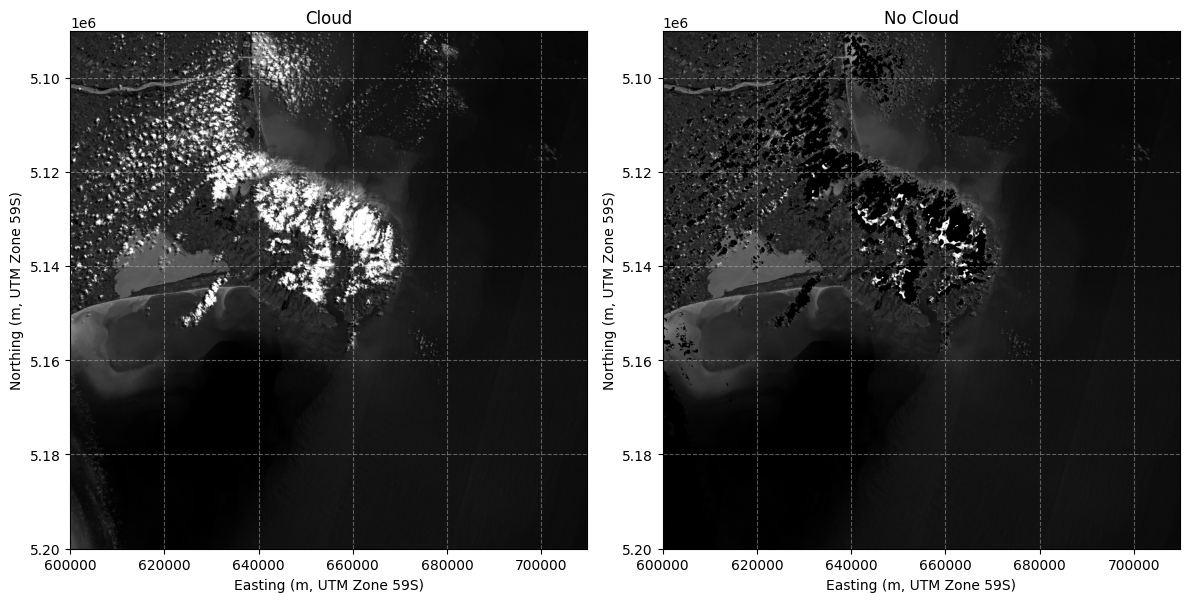

In [13]:
path = ["data_copernicus_unzip/S2B_MSIL2A_20181110T222539_N0500_R029_T59GPM_20230802T132516.SAFE/GRANULE/L2A_T59GPM_A008778_20181110T222535/IMG_DATA/R20m/T59GPM_20181110T222539_B03_20m.jp2",
        "B03_masked.tif"]
title=["Cloud","No Cloud"]
axe=("Easting (m, UTM Zone 59S)","Northing (m, UTM Zone 59S)")
display_images(path,title,axis_labels=axe)

---

## Normalization


In [ ]:
in_path = "T59GPM_20190305T222531_B03_20m.jp2"
out_path = "T59GPM_B03_normalize.tif"

ds = gdal.Open(in_path)
band = ds.GetRasterBand(1).ReadAsArray()

min_val = np.min(band[band != ds.GetRasterBand(1).GetNoDataValue()]) #if the band has nodata value set, we don't take this value in consideration   
max_val = np.max(band[band != ds.GetRasterBand(1).GetNoDataValue()])
norm_band = (band - min_val) / (max_val - min_val)

driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(out_path, ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
out_ds.SetGeoTransform(ds.GetGeoTransform())
out_ds.SetProjection(ds.GetProjection())

out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(norm_band)
out_band.SetNoDataValue(np.nan)

ds = None
out_ds = None


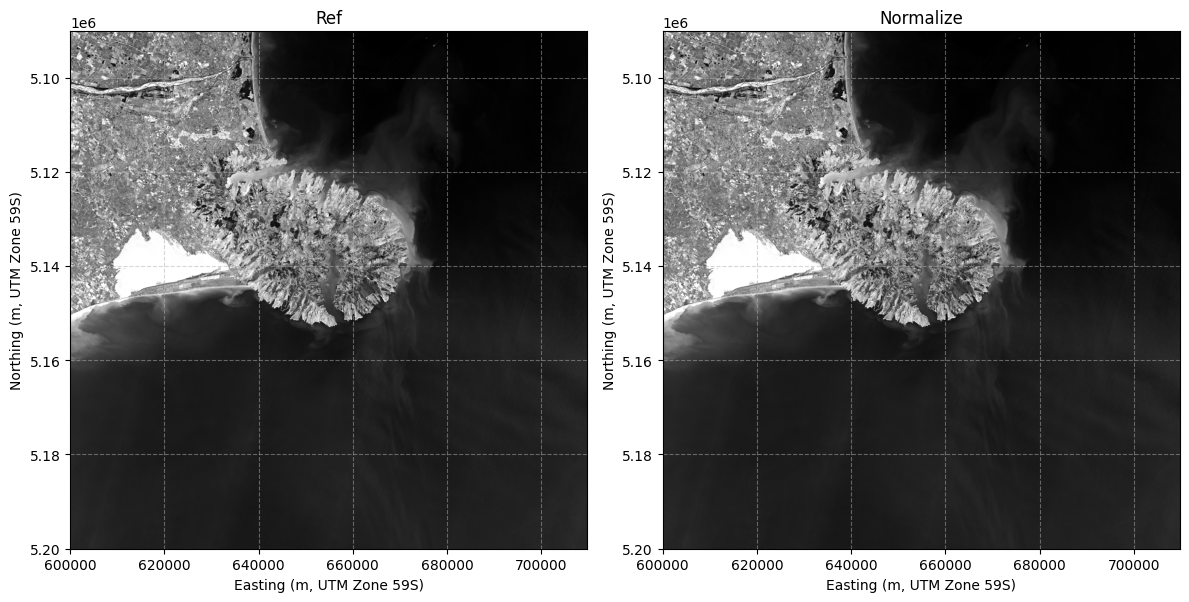

In [3]:
path = ["T59GPM_20190305T222531_B03_20m.jp2","T59GPM_B03_normalize.tif"]
title=["Ref","Normalize"]
axe=("Easting (m, UTM Zone 59S)","Northing (m, UTM Zone 59S)")
colorbar=True
display_images(path,title,"individual",axis_labels=axe)